# Examples

## Data

In [23]:
%matplotlib inline
import numpy as np
from linearmodels.datasets import munnell
data = munnell.load()

regions = {
    'GF':['AL', 'FL', 'LA', 'MS'],
    'MW':['IL', 'IN', 'KY', 'MI', 'MN', 'OH', 'WI'],
    'MA':['DE', 'MD', 'NJ', 'NY', 'PA', 'VA'],
    'MT' :['CO', 'ID', 'MT', 'ND', 'SD', 'WY'],
    'NE' :['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'SO' :['GA', 'NC', 'SC', 'TN', 'WV', 'AR'],
    'SW' : ['AZ', 'NV', 'NM', 'TX', 'UT'],
    'CN': ['AK', 'IA','KS', 'MO','NE','OK'],
    'WC': ['CA','OR','WA']
}

def map_region(state):
    for key in regions:
        if state in regions[key]:
            return key


data['REGION'] = data.ST_ABB.map(map_region)
data['TOTAL_EMP'] = data.groupby(['REGION','YR'])['EMP'].transform('sum')
data['EMP_SHARE'] = data.EMP / data.TOTAL_EMP
data['WEIGHED_UNEMP'] = data.EMP_SHARE * data.UNEMP

In [24]:
grouped = data.groupby(['REGION','YR'])
agg_data = grouped[['GSP','PC','HWY','WATER','UTIL','EMP','WEIGHED_UNEMP']].sum()
for col in ['GSP','PC','HWY','WATER','UTIL','EMP']:
    agg_data['ln'+col] = np.log(agg_data[col])
agg_data['UNEMP'] = agg_data.WEIGHED_UNEMP
agg_data['Intercept'] = 1.0

## Basic Usage

In [25]:
from collections import OrderedDict
mod_data = OrderedDict()
for region in ['GF','SW','WC','MT','NE','MA','SO','MW','CN']:
    region_data = agg_data.loc[region]
    dependent = region_data.lnGSP
    exog = region_data[['Intercept', 'lnPC', 'lnHWY', 'lnWATER', 'lnUTIL', 'lnEMP', 'UNEMP']]
    mod_data[region] = {'dependent': dependent, 'exog': exog}

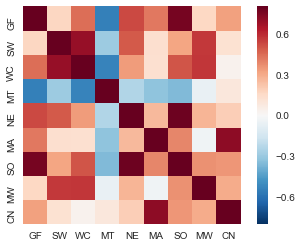

,GF,SW,WC,MT,NE,MA,SO,MW,CN
GF,1.000,0.173,0.447,-0.547,0.525,0.425,0.763,0.167,0.325
SW,0.173,1.000,0.697,-0.290,0.489,0.132,0.314,0.565,0.119
WC,0.447,0.697,1.000,-0.537,0.343,0.130,0.505,0.574,0.037
MT,-0.547,-0.290,-0.537,1.000,-0.241,-0.322,-0.351,-0.058,0.091
NE,0.525,0.489,0.343,-0.241,1.000,0.259,0.783,0.269,0.200
MA,0.425,0.132,0.130,-0.322,0.259,1.000,0.388,-0.037,0.713
SO,0.763,0.314,0.505,-0.351,0.783,0.388,1.000,0.366,0.350
MW,0.167,0.565,0.574,-0.058,0.269,-0.037,0.366,1.000,0.298
CN,0.325,0.119,0.037,0.091,0.200,0.713,0.350,0.298,1.000


In [26]:
import pandas as pd
from linearmodels.system import SUR
mod = SUR(mod_data)
res = mod.fit(cov_type='unadjusted', method='gls', debiased=True, iter_limit=10)
cov = res.sigma
std = np.sqrt(np.diag(res.sigma)[:,None])
regions =  [k for k in mod_data.keys()]
corr = pd.DataFrame(cov / (std @ std.T), columns=regions, index=regions)

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

corr.style.format('{:0.3f}')

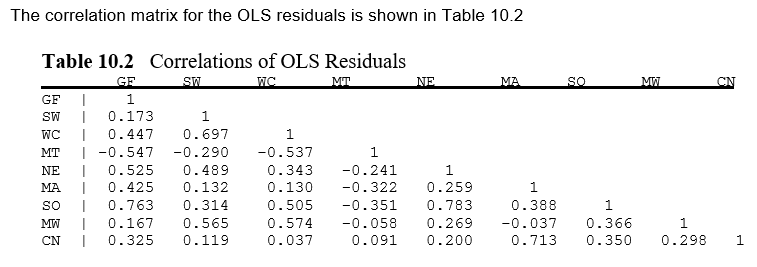

In [27]:
from IPython.display import Image, display_png
display_png(Image('correct-greene-table-10-2.png'))

In [28]:
print(res)

                        System GLS Estimation Summary                         
Estimator:                        GLS   Overall R-squared:              0.9988
No. Equations.:                     9   Cov. Estimator:             unadjusted
No. Observations:                  17   Num. Constraints:                 None
Date:                Tue, Jun 13 2017                                         
Time:                        12:26:46                                         
                                                                              
                                                                              
                   Equation: GF, Dependent Variable: lnGSP                    
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      12.310     2.1216     5.8023     0.0002      7.5829      17.037
lnPC          -0.2010     0.1321    -1.5219     0.15

In [29]:
print(res.equations['GF'])

                            GLS Estimation Summary                            
Eq. Label:                         GF   R-squared:                      0.9994
Dep. Variable:                  lnGSP   Adj. R-squared:                 0.9990
Estimator:                        GLS   Cov. Estimator:             unadjusted
No. Observations:                  17   F-statistic:                    489.97
Date:                Tue, Jun 13 2017   P-value (F-stat)                0.0000
Time:                        12:26:46   Distribution:                  F(6,10)
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      12.310     2.1216     5.8023     0.0002      7.5829      17.037
lnPC          -0.2010     0.1321    -1.5219     0.15

In [30]:
params = []
for label in res.equation_labels:
    params.append(res.equations[label].params)
params = pd.concat(params,1)
params.columns = res.equation_labels
params.T.style.format('{:0.3f}')

,Intercept,lnPC,lnHWY,lnWATER,lnUTIL,lnEMP,UNEMP
GF,12.310,-0.201,-1.886,0.178,1.190,0.953,-0.003
SW,4.083,0.077,-0.131,-0.136,0.522,0.539,-0.016
WC,1.960,0.170,0.132,-0.347,0.090,1.070,-0.006
MT,3.463,-0.115,0.180,0.262,-0.330,1.079,-0.001
NE,-12.294,0.118,0.934,-0.557,-0.290,2.494,0.020
MA,-18.616,-0.311,3.060,-0.109,-1.659,2.186,0.018
SO,3.162,-0.063,-0.641,-0.081,0.281,1.620,0.008
MW,-9.258,0.096,1.612,0.694,-0.340,-0.062,-0.031
CN,-3.405,0.295,0.934,0.539,0.003,-0.321,-0.029


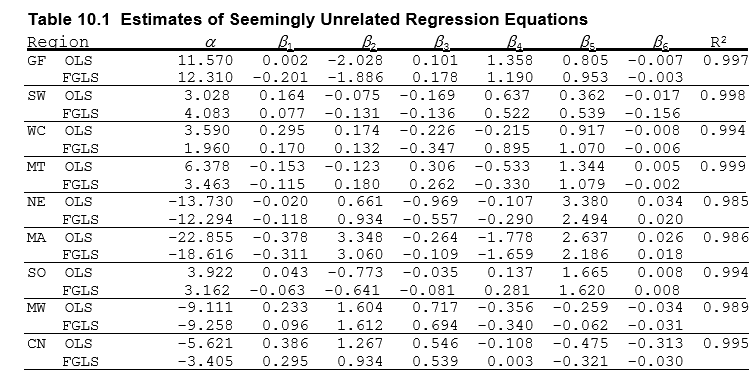

In [31]:
display_png(Image('correct-greene-table-10-1.png'))

In [32]:
res_ols = mod.fit(method='ols', debiased=True, cov_type='unadjusted')
params = []
r2 = []
for label in res.equation_labels:
    params.append(res_ols.equations[label].params)
    r2.append(res_ols.equations[label].rsquared)
params = pd.concat(params,1)
params.columns = res.equation_labels
params = params.T
params['R2'] = r2
params.style.format('{:0.3f}')

,Intercept,lnPC,lnHWY,lnWATER,lnUTIL,lnEMP,UNEMP,R2
GF,11.567,0.002,-2.029,0.101,1.358,0.805,-0.007,0.997
SW,3.028,0.164,-0.075,-0.169,0.637,0.362,-0.017,0.998
WC,3.590,0.295,0.174,-0.226,-0.214,0.917,-0.008,0.994
MT,6.378,-0.153,-0.123,0.306,-0.533,1.344,0.005,0.999
NE,-13.730,-0.020,0.662,-0.969,-0.107,3.380,0.034,0.985
MA,-22.855,-0.378,3.348,-0.264,-1.778,2.673,0.026,0.986
SO,3.927,0.043,-0.773,-0.035,0.140,1.665,0.008,0.994
MW,-9.111,0.233,1.604,0.717,-0.356,-0.259,-0.034,0.989
CN,-5.621,0.386,1.267,0.546,-0.108,-0.475,-0.031,0.995


In [33]:
params = pd.concat([res_ols.params.iloc[1::7], res_ols.std_errors.iloc[1::7], 
 res.params.iloc[1::7], res.std_errors.iloc[1::7]],1)
params.columns=['OLS', 'OLS se', 'GLS', 'GLS se']
params.index = regions
params

,OLS,OLS se,GLS,GLS se
GF,0.002124,0.301235,-0.200966,0.132051
SW,0.163546,0.165995,0.076637,0.096507
WC,0.294855,0.205417,0.169950,0.081267
MT,-0.152601,0.084031,-0.114834,0.059394
NE,-0.020407,0.285621,0.118316,0.127421
MA,-0.377570,0.167307,-0.310861,0.083619
SO,0.042818,0.279472,-0.063212,0.077437
MW,0.233403,0.206248,0.095886,0.099665
CN,0.385885,0.211083,0.294570,0.079944


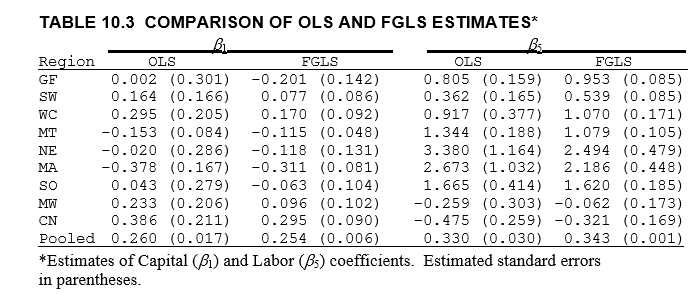

In [34]:
display_png(Image('correct-greene-table-10-3.png'))

In [35]:
res_het = mod.fit(cov_type='robust', debiased=True)
print(res_het)

                        System GLS Estimation Summary                         
Estimator:                        GLS   Overall R-squared:              0.9988
No. Equations.:                     9   Cov. Estimator:                 robust
No. Observations:                  17   Num. Constraints:                 None
Date:                Tue, Jun 13 2017                                         
Time:                        12:26:47                                         
                                                                              
                                                                              
                   Equation: GF, Dependent Variable: lnGSP                    
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      12.310     1.3785     8.9299     0.0000      9.2385      15.382
lnPC          -0.2010     0.0817    -2.4596     0.03

## Estimation Options

### Restricted Residual Covariance

### Iterative GLS

In [36]:
mod.fit(cov_type='unadjusted',debiased=True,iterate=True)

c:\git\linearmodels\linearmodels\system\results.py:69: RuntimeWarning: invalid value encountered in sqrt
  std_errors = sqrt(diag(self.cov))
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


System Iterative GLS Estimation Summary                    
==============================================================================
Estimator:              Iterative GLS   Overall R-squared:              1.0000
No. Equations.:                     9   Cov. Estimator:             unadjusted
No. Observations:                  17   Num. Constraints:                 None
Date:                Tue, Jun 13 2017                                         
Time:                        12:26:47                                         
                                                                              
                                                                              
                   Equation: GF, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -8.2995     158.73    -0.0523     0.9593     -361.98      345.38
lnPC           7.7508                              nan                        
lnHWY          0.1562     24.959     0.0063     0.9951     -55.455      55.767
lnWATER       -1.3903                              nan                        
lnUTIL        -6.1436                              nan                        
lnEMP         -2.6369     27.422    -0.0962     0.9253     -63.736      58.462
UNEMP          0.0266                              nan                        
                                                                              
                   Equation: SW, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -114.52     1060.0    -0.1080     0.9161     -2476.4      2247.4
lnPC           22.835     158.32     0.1442     0.8882     -329.92      375.59
lnHWY          2.6644     57.597     0.0463     0.9640     -125.67      131.00
lnWATER       -28.761     111.43    -0.2581     0.8016     -277.04      219.52
lnUTIL         20.925                              nan                        
lnEMP         -12.424     118.29    -0.1050     0.9184     -276.00      251.15
UNEMP         -0.2314     1.5695    -0.1475     0.8857     -3.7285      3.2657
                                                                              
                   Equation: WC, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -72.457                              nan                        
lnPC           4.0118     55.400     0.0724     0.9437     -119.43      127.45
lnHWY          11.773     59.160     0.1990     0.8463     -120.04      143.59
lnWATER       -0.9513     17.941    -0.0530     0.9588     -40.926      39.023
lnUTIL        -8.4121     45.816    -0.1836     0.8580     -110.50      93.672
lnEMP          0.5016     31.662     0.0158     0.9877     -70.046      71.049
UNEMP         -0.3842     2.8538    -0.1346     0.8956     -6.7428      5.9744
                                                                              
                   Equation: MT, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -197.11     771.56    -0.2555     0.8035     -1916.2      1522.0
lnPC           5.1760     56.577     0.0915     0.9289     -120.89   

### Alternative Covariance Estimators

In [37]:
mod.fit(cov_type='robust',debiased=True)
mod.fit(cov_type='robust',)

System GLS Estimation Summary                         
==============================================================================
Estimator:                        GLS   Overall R-squared:              0.9988
No. Equations.:                     9   Cov. Estimator:                 robust
No. Observations:                  17   Num. Constraints:                 None
Date:                Tue, Jun 13 2017                                         
Time:                        12:26:47                                         
                                                                              
                                                                              
                   Equation: GF, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      12.310     1.0573     11.643     0.0000      10.238      14.382
lnPC          -0.2010     0.0627    -3.2069     0.0013     -0.3238     -0.0781
lnHWY         -1.8856     0.2601    -7.2484     0.0000     -2.3955     -1.3758
lnWATER        0.1785     0.0184     9.7034     0.0000      0.1424      0.2145
lnUTIL         1.1898     0.1942     6.1270     0.0000      0.8092      1.5703
lnEMP          0.9533     0.0397     24.022     0.0000      0.8755      1.0311
UNEMP         -0.0031     0.0012    -2.5187     0.0118     -0.0055     -0.0007
                                                                              
                   Equation: SW, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      4.0831     0.6495     6.2862     0.0000      2.8100      5.3561
lnPC           0.0766     0.0531     1.4428     0.1491     -0.0275      0.1807
lnHWY         -0.1312     0.0779    -1.6838     0.0922     -0.2839      0.0215
lnWATER       -0.1360     0.0445    -3.0550     0.0023     -0.2232     -0.0487
lnUTIL         0.5216     0.0901     5.7891     0.0000      0.3450      0.6982
lnEMP          0.5387     0.0592     9.0983     0.0000      0.4226      0.6547
UNEMP         -0.0156     0.0024    -6.4330     0.0000     -0.0204     -0.0109
                                                                              
                   Equation: WC, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.9602     1.5208     1.2889     0.1974     -1.0205      4.9408
lnPC           0.1699     0.0654     2.5982     0.0094      0.0417      0.2982
lnHWY          0.1317     0.0777     1.6940     0.0903     -0.0207      0.2840
lnWATER       -0.3470     0.1268    -2.7364     0.0062     -0.5955     -0.0985
lnUTIL         0.0895     0.2225     0.4023     0.6874     -0.3466      0.5256
lnEMP          1.0696     0.0971     11.012     0.0000      0.8792      1.2600
UNEMP         -0.0060     0.0023    -2.6413     0.0083     -0.0104     -0.0015
                                                                              
                   Equation: MT, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.4633     0.8860     3.9088     0.0001      1.7267      5.1998
lnPC          -0.1148     0.0305    -3.7624     0.0002     -0.1747     -0.

## Pre-specified Residual Covariance Estimators

In [38]:
avg_corr = (corr - np.eye(9)).mean().mean() * (81/72)
rho = np.ones((9,9)) * avg_corr  + (1-avg_corr) * np.eye(9)
sigma_pre = rho * (std @ std.T)
mod_pre_sigma = SUR(mod_data, sigma=sigma_pre)
res_pre = mod_pre_sigma.fit(cov_type='unadjusted', debiased=True)
print(res_pre.equations['GF'])

                            GLS Estimation Summary                            
Eq. Label:                         GF   R-squared:                      0.9958
Dep. Variable:                  lnGSP   Adj. R-squared:                 0.9933
Estimator:                        GLS   Cov. Estimator:             unadjusted
No. Observations:                  17   F-statistic:                    486.05
Date:                Tue, Jun 13 2017   P-value (F-stat)                0.0000
Time:                        12:26:47   Distribution:                  F(6,10)
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      7.9753     3.6260     2.1995     0.0525     -0.1038      16.054
lnPC           0.1011     0.2286     0.4424     0.66

## Cross-Equation Restrictions

In [39]:
mod.param_names[:14]

['GF_Intercept',
 'GF_lnPC',
 'GF_lnHWY',
 'GF_lnWATER',
 'GF_lnUTIL',
 'GF_lnEMP',
 'GF_UNEMP',
 'SW_Intercept',
 'SW_lnPC',
 'SW_lnHWY',
 'SW_lnWATER',
 'SW_lnUTIL',
 'SW_lnEMP',
 'SW_UNEMP']

In [40]:
r = pd.DataFrame(columns=mod.param_names, index=['rest{0}'.format(i) for i in range(1,9)], dtype=np.float64)
r.loc[:,:] = 0.0
r.iloc[:,6] = -1.0
r.iloc[:,13::7] = np.eye(8)
print(r.iloc[:,6::7])

       GF_UNEMP  SW_UNEMP  WC_UNEMP  MT_UNEMP  NE_UNEMP  MA_UNEMP  SO_UNEMP  \
rest1      -1.0       1.0       0.0       0.0       0.0       0.0       0.0   
rest2      -1.0       0.0       1.0       0.0       0.0       0.0       0.0   
rest3      -1.0       0.0       0.0       1.0       0.0       0.0       0.0   
rest4      -1.0       0.0       0.0       0.0       1.0       0.0       0.0   
rest5      -1.0       0.0       0.0       0.0       0.0       1.0       0.0   
rest6      -1.0       0.0       0.0       0.0       0.0       0.0       1.0   
rest7      -1.0       0.0       0.0       0.0       0.0       0.0       0.0   
rest8      -1.0       0.0       0.0       0.0       0.0       0.0       0.0   

       MW_UNEMP  CN_UNEMP  
rest1       0.0       0.0  
rest2       0.0       0.0  
rest3       0.0       0.0  
rest4       0.0       0.0  
rest5       0.0       0.0  
rest6       0.0       0.0  
rest7       1.0       0.0  
rest8       0.0       1.0  


In [41]:
mod.add_constraints(r)
rest_res = mod.fit(cov_type='unadjusted', debiased=True)
print(rest_res.params.iloc[6::7])

GF_UNEMP   -0.005801
SW_UNEMP   -0.005801
WC_UNEMP   -0.005801
MT_UNEMP   -0.005801
NE_UNEMP   -0.005801
MA_UNEMP   -0.005801
SO_UNEMP   -0.005801
MW_UNEMP   -0.005801
CN_UNEMP   -0.005801
Name: params, dtype: float64


## Multivariate OLS

In [42]:
import statsmodels.api as sm
from linearmodels.datasets import french
data = french.load()
factors = sm.add_constant(data[['MktRF']])
mv_ols = SUR.multivariate_ls(data[['S1V1','S1V3','S1V5','S5V1','S5V3','S5V5']], factors)
mv_ols_res = mv_ols.fit(cov_type='unadjusted')
print(mv_ols_res)

                        System OLS Estimation Summary                         
Estimator:                        OLS   Overall R-squared:              0.6564
No. Equations.:                     6   Cov. Estimator:             unadjusted
No. Observations:                 819   Num. Constraints:                 None
Date:                Tue, Jun 13 2017                                         
Time:                        12:26:47                                         
                                                                              
                                                                              
                   Equation: S1V1, Dependent Variable: S1V1                   
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0020     0.0017    -1.1608     0.2457     -0.0054      0.0014
MktRF          1.3736     0.0403     34.101     0.00

## Using GLS with common regressors

In [43]:
print(mv_ols.fit(cov_type='unadjusted', method='gls'))

                        System GLS Estimation Summary                         
Estimator:                        GLS   Overall R-squared:              0.8776
No. Equations.:                     6   Cov. Estimator:             unadjusted
No. Observations:                 819   Num. Constraints:                 None
Date:                Tue, Jun 13 2017                                         
Time:                        12:26:47                                         
                                                                              
                                                                              
                   Equation: S1V1, Dependent Variable: S1V1                   
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0020     0.0017    -1.1608     0.2457     -0.0054      0.0014
MktRF          1.3736     0.0403     34.101     0.00